# A/B Testing

#### Does reducing website text lead to more sign-up demos?

Our objective is to determine whether reducing the amount of text on a company's website, which sells a digital product, and presenting users with a simplified version will result in an increase in sign-up demos.

**Variant A**: Control Group - Current website with extensive text.

**Variant B**: Test Group - Light version of the website.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Libraries
import datetime
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
from scipy import stats

## Load Historical Data

In [2]:
df_2020 = pd.read_csv('historical_data.csv')
df_2020.head()

,id,demo,date
0,0x6f9421,False,2020-12-26
1,0x59d442,False,2020-08-16
2,0x6db8f8,True,2020-03-18
3,0x68245d,False,2020-02-13
4,0x28566e,False,2020-09-28


In [3]:
df_2020['date'] = pd.to_datetime(df_2020['date'])

## Choosing primary metric for the A/B test

We'll use this metric to measure the performance of the changes on the website for the control and experimental groups and to identify whether there is a statistically significant difference between these two.

The expectation is that if the website gets more demos, then this suggests the content is working. 

We'll use **Conversion Rate**, defined as the proportion of sessions ending up with a transaction, in this case users **signing up for a demo**.

CR = #CONVERTED / (#CONVERTED + #NOTCONVERTED)

## Stating the hypothesis of the test

## Designing the A/B test

### Step 1: Statistical Hypothesis

Assuming that Variant A is the control group or the current website with extensive text, and Variant B is the test group or the light version of the website, we will consider Variant B superior only if it proves to be better at a Type I error rate of 5%.

We will define our hypotheses as PA and PB, representing the conversion probabilities (sign-up demos) for Variant A and Variant B, respectively.

**H0: PB - PA = 0**

**H1: PB - PA > 0**

The null hypothesis (H0) states that there is no significant difference in conversion probability between the two variants, indicating that the amount of text on the website does not affect the chances of conversion.

The alternative hypothesis (H1) states that there is a significant difference in conversion probability between the two variants, implying that the amount of text on the website may impact the likelihood of conversion.

### Step 2: Metric to measure the success of the experiment

Conversion rate, which is the percentage of visitors who sign up to try the demo product.

### Step 3: Power Analysis

$\beta$ | Probability of Type II Error = 0.2

1 - $\beta$ | Power of the test = 0.8

$\alpha$ | Probability of Type I Error | Significance Level = 0.05

$\delta$ | Minimum Detectable Effect

In [4]:
alpha = 0.05  # significance level
power = 0.8  # power

To determine the success of the A/B experiment, we can calculate the conversion rate for each group, which is the number of conversions (successful sign-up demos) divided by the total number of visitors to the page. This conversion rate is equivalent to the probability of success, denoted by $p$, in a binomial distribution.

Since the current website has a lot of text that may be confusing to users, we want to test whether reducing the amount of text by at least half will increase the number of sign-up demos. 

To calculate the conversion rate baseline, we will use historical data from the past year.

In [5]:
# baseline conversion
bcr = df_2020['demo'].mean()
bcr

0.1519305311938327

In [6]:
# Z_α/2 = critical value of the standard normal distribution for the level of significance
z_a2 = 1.96

In [7]:
# σ = estimated standard deviation of conversion rate (we'll use historical data)
std_dev = np.sqrt(bcr * (1 - bcr) / df_2020.shape[0])

In [8]:
# For conversion estimated for treatment group we'll use business target 20%
target_conversion = 0.19

In [9]:
# smallest effect that would matter in practice for the business
mde = target_conversion - bcr
mde

0.038069468806167295

### Step 4: Calculating sample size

The z-score corresponds to a certain number of standard deviations from the mean of a normal distribution. By calculating the z-score for a specific alpha level and power, we can determine the number of standard deviations away from the null hypothesis we need to be to reject it. 

In [10]:
def min_sample_size(p_A, mde, power, alpha, two_sided = True):
   
    # Normal distribution to determine z
    standard_norm = scs.norm(0, 1)

    # z-score for the desired power
    Z_beta = standard_norm.ppf(power)
    
    # z-score for the desired significance level
    if two_sided == True:
        Z_alpha = standard_norm.ppf(1 - alpha / 2)
        
    else:
        Z_alpha = standard_norm.ppf(1 - alpha)

    # Average probability of the two groups
    pooled_prob = (p_A + (p_A + mde)) / 2

    # Min sample size
    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2 / mde **2)    

    return min_N

In [11]:
sample_size = min_sample_size(bcr, mde, power, alpha)
print(f'The required sample size for each group is: {round(sample_size, 0)}')

The required sample size for each group is: 1535.0


### Step 5: Determining A/B test duration

This needs to be answered before running the experiment. One approach could be using the following formula:

DURATION = N / #DAILY_VISITORS

In [12]:
N = round(sample_size * 2, 0)
N

3070.0

In [13]:
# Daily Visitors
daily_visitors = df_2020.groupby('date')['id'].nunique()
avg_visitors_per_day = round(daily_visitors.sum() / daily_visitors.count(),0)
print(f'Average visitors per day: {avg_visitors_per_day}')

Average visitors per day: 127.0


In [14]:
test_duration = round(N / avg_visitors_per_day, 0)
print(f'Test Duration: {test_duration} days')

Test Duration: 24.0 days


## Running the A/B test

### Load Test Data

In [15]:
df = pd.read_csv('test_data.csv')
df.head()

,id,variant,demo,date
0,0x49d29c,A,False,2021-01-06
1,0x29c248,A,False,2021-01-12
2,0x825ee6,A,False,2021-01-03
3,0x7a2332,A,False,2021-01-12
4,0x2dca2a,A,False,2021-01-10


In [16]:
df['date'] = pd.to_datetime(df['date'])

### EDA

In [17]:
df.shape

(3070, 4)

In [18]:
df.isnull().sum()

id         0
variant    0
demo       0
date       0
dtype: int64

In [19]:
df['demo'].value_counts()

False    2529
True      541
Name: demo, dtype: int64

In [20]:
df['variant'].value_counts()

A    1535
B    1535
Name: variant, dtype: int64

#### Probabilities

In [21]:
# probability of user exposed to variant A
df[df['variant'] == 'A'].shape[0] / df.shape[0] * 100

50.0

In [22]:
# probability of user exposed to variant A
df[df['variant'] == 'B'].shape[0] / df.shape[0] * 100

50.0

### Total users who signed for demos 

In [23]:
conversions = df['demo'].sum()
conversions

541

In [24]:
# Conversions when variant is A
df[df['variant'] == 'A']['demo'].sum()

241

In [25]:
# Conversions when variant is B
df[df['variant'] == 'B']['demo'].sum()

300

In [26]:
# Conversion Probability independent of variant
df['demo'].mean()

0.1762214983713355

In [27]:
# Conversion Probability when the user was exposed to variant A
df[df['variant'] == 'A']['demo'].mean()

0.15700325732899023

In [28]:
# Conversion Probability when the user was exposed to variant A
df[df['variant'] == 'B']['demo'].mean()

0.19543973941368079

The probability of being exposed to either variant is equal, but the probability of conversion is approximately 19% for the new variant, compared to around 16% for the old variant. 

Our goal now is to ensure that we have sufficient evidence to conclude that the treatment group (B) results in a significant increase in conversions.

## Analyzing test results

In [29]:
df_ab = df[['variant', 'demo']].rename(columns = {'variant':'group', 'demo': 'conversion'})
df_ab.head()

,group,conversion
0,A,False
1,A,False
2,A,False
3,A,False
4,A,False


In [30]:
# Summarized data
df_ab_summarized = df_ab.pivot_table(values = 'conversion', index = 'group', aggfunc = np.sum)
df_ab_summarized

,conversion
group,
A,241
B,300


In [31]:
df_ab_summarized['total'] = df_ab.pivot_table(values = 'conversion', index = 'group', aggfunc = 'count')
df_ab_summarized

,conversion,total
group,,
A,241,1535
B,300,1535


In [32]:
df_ab_summarized['rate'] = df_ab.pivot_table(values = 'conversion', index = 'group')
df_ab_summarized

,conversion,total,rate
group,,,
A,241,1535,0.157003
B,300,1535,0.195440


In [33]:
# Values for A
conversion_A = df_ab_summarized['conversion'][0]
total_A = df_ab_summarized['total'][0]
rate_A = df_ab_summarized['rate'][0]
print(f'Demos for A were: {conversion_A}')
print(f'Sample Size for A is: {total_A}')
print(f'Conversion rate for A is: {round(rate_A * 100, 2)}%')

Demos for A were: 241
Sample Size for A is: 1535
Conversion rate for A is: 15.7%


In [34]:
# Values for B
conversion_B = df_ab_summarized['conversion'][1]
total_B = df_ab_summarized['total'][1]
rate_B = df_ab_summarized['rate'][1]
print(f'Demos for B were: {conversion_B}')
print(f'Sample Size for B is: {total_B}')
print(f'Conversion rate for B is: {round(rate_B * 100, 2)}%')

Demos for B were: 300
Sample Size for B is: 1535
Conversion rate for B is: 19.54%


In [35]:
print(f'Difference in Conversion rate between groups is: {rate_B - rate_A}')
print(f'Difference in Conversion the business wanted to study: {mde}')

Difference in Conversion rate between groups is: 0.038436482084690554
Difference in Conversion the business wanted to study: 0.038069468806167295


### Comparing the two groups

Looks like the difference in conversion rates between the two groups it's slightly bigger than the target we set. A good sign, but not enough to confidently choose to change the entire website. 

We can start evaluating how confident we're in the result by looking at the distribution of the two groups.

In [36]:
print(f'Baseline Conversion rate was: {round(bcr * 100, 2)}%')

Baseline Conversion rate was: 15.19%


In [37]:
test_binom = scs.binom(total_A, p = bcr)

In [38]:
test_binom_mde = scs.binom(total_A, p = bcr + mde)

<BarContainer object of 1536 artists>

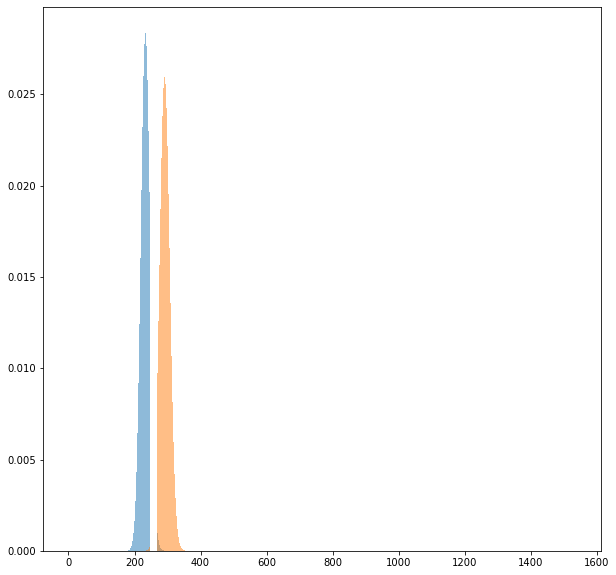

In [39]:
# Plot
fig, ax = plt.subplots(figsize = (10, 10))

# Values for X
x = np.linspace(0, int(total_A), int(total_A) + 1)

# Pmf & alfa
ax.bar(x, test_binom.pmf(x), alpha = 0.5)
ax.bar(x, test_binom_mde.pmf(x), alpha = 0.5)

Based on the chart, it appears that Variant B (orange) has a higher conversion than Variant A (blue). However, the peak point of Variant A suggests that it may have a higher probability of conversion at that particular point. While this chart provides some insights, it is important to consider the distribution of both groups to draw a more conclusive interpretation.

### Distribution

Let's plot the distribution of the control group and calculate the probability of obtaining the result observed in the experimental group.

The distribution of the control group represents what we would expect to see if there were no effect of the change made to the experimental group.

If the experimental group performs significantly better (or worse) than the control group, it suggests that the change made had an effect.

Text(0, 0.5, 'Probability')

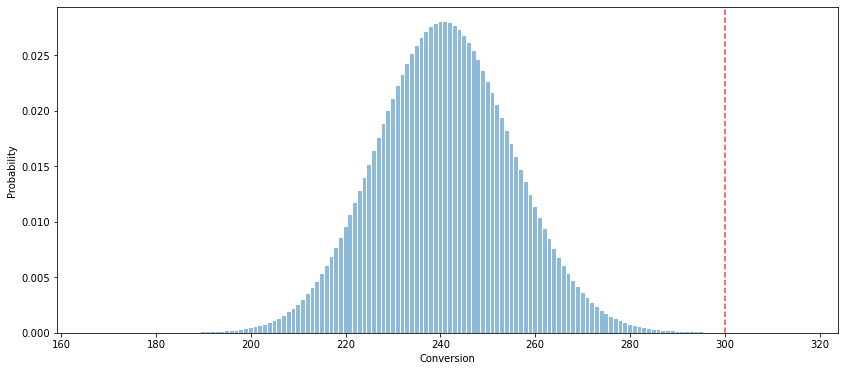

In [40]:
fig, ax = plt.subplots(figsize = (14, 6))

# Test A
x = np.linspace(conversion_A - 74, conversion_A + 75, 150)
y = scs.binom(total_A, rate_A).pmf(x)

# Bar that represents expected number of conversions for B if it had the same number of observations as Test A.
ax.bar(x, y, alpha = 0.5)
ax.axvline(x = rate_B * total_A, c = 'red', alpha = 0.75, linestyle = '--')

# Labels
plt.xlabel('Conversion')
plt.ylabel('Probability')

The distribution for the control group is shown in blue and the result from the test group is indicated by the red dashed line. We can see that the probability of getting the result from the test group (B) was close to cero.

However, probability alone does not convey the confidence level of the results. The confidence level represents how confident we are in the conclusion we draw based on the probability. It takes into account the sample size of the test group, which is the number of observations that we have in our experiment.

A larger sample size generally results in a more accurate estimate of the true population parameter (in this case, the conversion rate) and a higher level of confidence in the results. 

Let’s plot the test group results as a binomial distribution and compare the distributions against each other.

Text(0, 0.5, 'Probability')

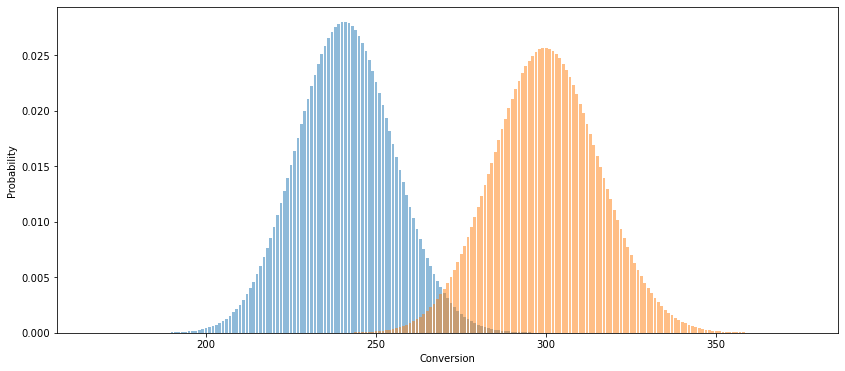

In [41]:
fig, ax = plt.subplots(figsize = (14, 6))

# A
xA = np.linspace(conversion_A - 74, conversion_A + 75, 150)
yA = scs.binom(total_A, rate_A).pmf(xA)
ax.bar(xA, yA, alpha = 0.5)

# B
xB = np.linspace(conversion_B - 74, conversion_B + 75, 150)
yB = scs.binom(total_B, rate_B).pmf(xB)
ax.bar(xB, yB, alpha = 0.5)

# Labels
plt.xlabel('Conversion')
plt.ylabel('Probability')

The test group (orange) converted more users than the control group (blue). Also, the peak of the test group results is lower than the control group. To interpret this difference in peak probability we need to standardize the data and compare the probability of successes, p, for each group.

#### Normal distribution to plot PDF for both variants

We are interested here to see the probability of observing each possible conversion rate within a range of values around the observed conversion rate.

In [42]:
p_A = rate_A
p_B = rate_B
N_A = total_A
N_B = total_B

In [43]:
# Standard error of the mean of each group
SE_A = np.sqrt(p_A * (1 - p_A)) / np.sqrt(total_A)
SE_B = np.sqrt(p_B * (1 - p_B)) / np.sqrt(total_B)

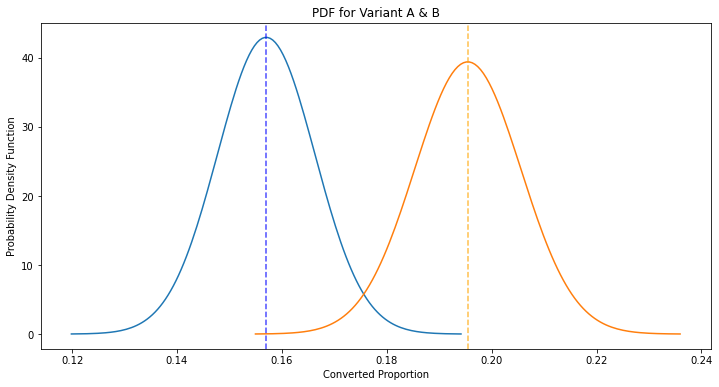

In [44]:
# Define the x-axis range for the plot
xA_SE = np.linspace(p_A - 4 * SE_A, p_A + 4 * SE_A, 150)
xB_SE = np.linspace(p_B - 4 * SE_B, p_B + 4 * SE_B, 150)

# Calculate the probability density function (PDF)
yA = scs.norm(p_A, SE_A).pdf(xA_SE)
yB = scs.norm(p_B, SE_B).pdf(xB_SE)

# Plot the PDF for variant A
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(xA_SE, yA)
ax.plot(xB_SE, yB)
ax.axvline(x = p_A, c = 'blue', alpha = 0.7, linestyle = '--')
ax.axvline(x = p_B, c = 'orange', alpha = 0.7, linestyle = '--')

# Add labels and title to the plot
plt.xlabel('Converted Proportion')
plt.ylabel('Probability Density Function')
plt.title('PDF for Variant A & B')

# Show the plot
plt.show()

The blue and orange solid lines indicate the average conversion rate for the control and test groups respectively. The difference between these lines represents the mean difference between the conversion rates of the two groups.

Curves of both variants cross each other, therefore there is a conversion rate where both are equally likely to perform better. 

However, since the peak of Variant A is higher than the peak of Variant B, it suggests that Variant A has a higher chance of performing better overall. 

### Probability Distribution for H0 and H1

The null hypothesis posits that there will be no significant difference in conversion rates between the control group and the test group, which was exposed to a reduced amount of text on the website.

In contrast, the alternative hypothesis predicts that reducing the amount of text on the website will result in a change in the conversion rate, either positive or negative.

To simulate the possible outcomes of the experiment, we will use the normal distribution. Under the null hypothesis, the distribution will have a mean of zero and a standard deviation equal to the pooled standard error. 

The alternative hypothesis will have the same standard deviation, but with the mean shifted to the difference in conversion rates between the control and test groups.

In [45]:
p_pool = (p_A * N_A + p_B * N_B) / (N_A + N_B)
print('Pooled probability: ', p_pool)

Pooled probability:  0.1762214983713355


In [46]:
z = (p_B - p_A) / (p_pool * (1 - p_pool) * (1 / N_A + 1 / N_B)) ** 0.5
z

2.794783381447436

In [47]:
# Check if z is greater than 1.64 (0.05 significance level)
z > 1.64

True

The value 1.64 corresponds to the z-score of the 95th percentile of the standard normal distribution. This means that if H0 is true and there is no real difference between the conversion rates of the two variants, the probability of observing a z-score greater than 1.64 (or less than -1.64) is 0.05 or less. 

This suggests that the probability of observing such a difference in convertion rates by chance alone is very low, and then we could reject the null hypothesis.

#### Probability Distribution Plot

In [48]:
# Function to return pooled probability
def pooled_prob(N_A, N_B, X_A, X_B):
    return (X_A + X_B) / (N_A + N_B)

In [49]:
# Function to return squared error for the two variants
def stan_sqr_error(N_A, N_B, X_A, X_B):
    p_hat = pooled_prob(N_A, N_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1 - p_hat) * (1 / N_A + 1 / N_B))
    return SE

In [50]:
# Return z for a given significance level
def z_val(sig_level = 0.05, two_tailed = True):
    
    # Distribution for z
    z_dist = scs.norm()
    
    # Checks if we should check both tails
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
        
    else:
        area = 1 - sig_level

    # Z value
    z = z_dist.ppf(area)

    return z

In [51]:
# Calculates the confidence interval
def confidence_interval(sample_mean = 0, sample_std = 1, sample_size = 1, sig_level = 0.05):
    
    # Z value
    z = z_val(sig_level)

    # Limits
    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)

    return (left, right)

In [52]:
# Function that calculates the two-tailed confidence interval
def plot_CI(ax, 
            mu, 
            s, 
            sig_level = 0.05, 
            color = 'grey'):

    # Confidence interval
    left, right = confidence_interval(sample_mean = mu, sample_std = s, sig_level = sig_level)
    
    # Add interval in chart
    ax.axvline(left, c = color, linestyle = '--', alpha = 0.5)
    ax.axvline(right, c = color, linestyle = '--', alpha = 0.5)

In [53]:
# Function to plot a normal distribution
def plot_norm_dist(ax, 
                   mu, 
                   std, 
                   with_CI = False, 
                   sig_level = 0.05, 
                   label = None):

    # Generates values for the random variable x
    x = np.linspace(mu - 12 * std, mu + 12 * std, 1000)
    
    # Creates normal distribution
    y = scs.norm(mu, std).pdf(x)
    
    # Plot
    ax.plot(x, y, label = label)

    # Confidence interval
    if with_CI:
        plot_CI(ax, mu, std, sig_level = sig_level)

In [54]:
# Plot H0
def plot_H0(ax, stderr):
    plot_norm_dist(ax, 0, stderr, label = "H0 - Null Hypothesis")
    plot_CI(ax, mu = 0, s = stderr, sig_level = 0.05)

In [55]:
# Plot H1
def plot_H1(ax, stderr, d_hat):
    plot_norm_dist(ax, d_hat, stderr, label = "H1 - Alternative Hypothesis")

In [56]:
# Function that fills between the upper significance limit and distribution for H1
def show_area(ax, d_hat, stderr, sig_level):

    # Confidence interval
    left, right = confidence_interval(sample_mean = 0, sample_std = stderr, sig_level = sig_level)
    
    # Values for x
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    
    # H0
    null = ab_dist(stderr, 'CONTROL')
    
    # H1
    alternative = ab_dist(stderr, d_hat, 'TEST')

    # If the type of the area equals power
    # We fill between the upper significance limit and the distribution for alternative hypothesis    
    ax.fill_between(x, 0, alternative.pdf(x), color = 'green', alpha = 0.25, where = (x > right))
    ax.text(-3 * stderr, null.pdf(0), 'power = {0:.3f}'.format(1 - alternative.cdf(right)), 
                fontsize = 12, ha = 'right', color = 'k')

In [57]:
# Creates a distribution object depending on the group type
def ab_dist(stderr, d_hat = 0, group_type = 'CONTROL'):

    if group_type == 'CONTROL':
        sample_mean = 0
    elif group_type == 'TEST':
        sample_mean = d_hat

    dist = scs.norm(sample_mean, stderr)
    return dist

In [58]:
# Function to return p_value
def p_val(N_A, N_B, p_A, p_B):
    return scs.binom(N_A, p_A).pmf(p_B * N_B)

In [59]:
# Function that fills between the upper significance limit and power
def show_area_power(ax, d_hat, stderr, sig_level):

    # Confidence interval
    left, right = confidence_interval(sample_mean = 0, sample_std = stderr, sig_level = sig_level)
    
    # Values for x
    x = np.linspace(-8 * stderr, 8 * stderr, 1000)
    
    # H0
    null = ab_dist(stderr, 'CONTROL')
    
    # H1
    alternative = ab_dist(stderr, d_hat, 'TEST')

    # Power
    power = 1 - alternative.cdf(right)

    # Fill the area between the right limit of the confidence interval and power
    ax.fill_between(x, 0, alternative.pdf(x), color = 'red', alpha = 0.25, where = (x > left) & (x <= right))

    # Add power text
    ax.text(-3 * stderr, null.pdf(0), 'power = {0:.3f}'.format(power), 
                fontsize = 12, ha = 'right', color = 'k')

In [69]:
# Function for plotting the A/B Test analysis
def abplot_func(N_A, 
                N_B, 
                bcr, 
                d_hat, 
                sig_level = 0.05, 
                show_p_value = False,
                show_legend = True,
                show_beta = True):
   
    fig, ax = plt.subplots(figsize = (14, 8))

    # Defines parameters to find pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = stan_sqr_error(N_A, N_B, X_A, X_B)

    # Plot H0 & H1
    plot_H0(ax, stderr)
    plot_H1(ax, stderr, d_hat)

    # Set the extent of the plot area
    ax.set_xlim(-8 * stderr, 8 * stderr)

    # We adjust the graphic and fill inner area
    show_area(ax, d_hat, stderr, sig_level)
    
    # Fill the power area
    if show_beta:
        show_area_power(ax, d_hat, stderr, sig_level)
    
    # We show p-values based on the distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'CONTROL')
        p_value = p_val(N_A, N_B, bcr, bcr + d_hat)
        ax.text(3 * stderr, null.pdf(0), 'Valor-p = {0:.4f}'.format(p_value), fontsize = 14, ha = 'left')

    # Legend
    if show_legend:
        plt.legend(loc = 'center right')
    
    ax.set_title('A/B Test Analysis | Statistical Power and Significance Level', fontsize=20)
    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()

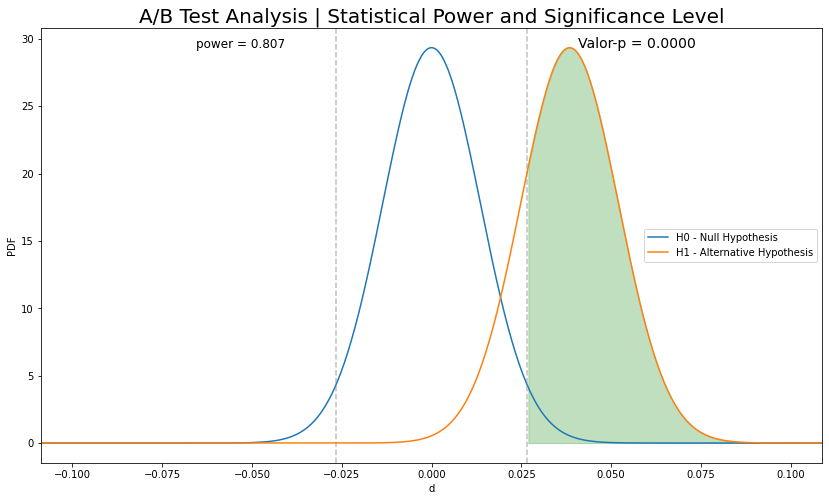

In [70]:
# Execute function
n = N_A + N_B
d_hat = p_B - p_A
abplot_func(N_A, N_B, bcr, d_hat, show_p_value = True, show_beta = False)

Green area = True Positives, represents the statistical power. <br>
Grey dashed lines = confidence interval (95%) of H0.<br>
Red area = Beta. Probability of accepting H0 and reject H1 (false negative).

Statistical power is calculated by finding the area under the alternative hypothesis distribution and outside of the confidence interval of the null hypothesis.

Once the experiment was completed, we obtained a conversion rate for each group. By calculating the difference between the two rates, we obtain the effect of the change in the amount of text on the website. Our goal is to identify which hypothesis, null or alternative, the effect belongs to.

The alternative hypothesis curve has an area of 1, which represents the possibility that the alternative design is better. The power of the test is the probability of correctly accepting the alternative hypothesis and rejecting the null hypothesis, which is represented by the green area.

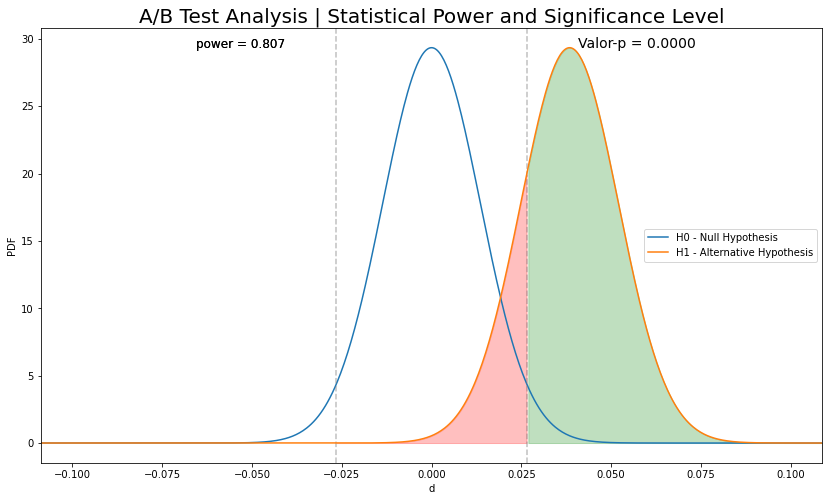

In [62]:
abplot_func(N_A, N_B, bcr, d_hat, show_p_value = True, show_beta = True)

### Conclusion 

Based on the power of the analysis, which was 0.807, we can conclude that **there is a high probability that the difference between variant A and B is statistically significant**. This means that the difference in performance between the two variants is likely not due to chance.

Since variant B performed better than variant A, we can confidently conclude that implementing variant B on the website will result in a higher conversion rate, which aligns with the goal of the analysis - to increase the number of demos.

By reducing the amount of text on the website and implementing variant B, the company is likely to see an increase in the number of demos, as users are more likely to engage with the website and take the desired action.